<a href="https://colab.research.google.com/github/ShankarChavan/synthetic-data-generation/blob/main/SDV/PAR/Sequence_data(Time_Series).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install sdv
!pip install ydata-profiling

# PAR (Probabilistic AutoRegressive model)

We will use PAR that allows learning multi-type, multivariate timeseries data and later on generate new synthetic data that has the same format and properties as the learned one.

## Loading Demo Data

In [4]:
from sdv.datasets.demo import download_demo
real_data, metadata = download_demo(
    modality='sequential',
    dataset_name='nasdaq100_2019'
)

**Details**: The data is available as a single table.
- `Symbol` describes the ticker symbol of the company
- `Date` describes the point of time that the prices correspond to
-  Columns such as `Open`, `Close` and `Volume` are measurements that change daily
- Columns such `Sector` and `Industry` describe fixed, unchanging values for every company

In [5]:
real_data.head()

,Symbol,Date,Open,Close,Volume,MarketCap,Sector,Industry
0,AAPL,2018-12-31,39.632500,39.435001,140014000,7.378734e+11,Technology,Computer Manufacturing
1,AAPL,2019-01-02,38.722500,39.480000,148158800,7.378734e+11,Technology,Computer Manufacturing
2,AAPL,2019-01-03,35.994999,35.547501,365248800,7.378734e+11,Technology,Computer Manufacturing
3,AAPL,2019-01-04,36.132500,37.064999,234428400,7.378734e+11,Technology,Computer Manufacturing
4,AAPL,2019-01-07,37.174999,36.982498,219111200,7.378734e+11,Technology,Computer Manufacturing


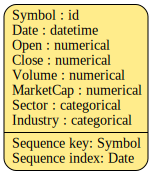

In [6]:
metadata.visualize()

A **sequence** is a set of measurements taken in a particular order, such as the Open, Close and Volume of stock prices. Some datasets have a sequence index that prescribes this order. In our case, the Date column.

In [7]:
amzn_sequence = real_data[real_data['Symbol'] == 'AMZN']
amzn_sequence

,Symbol,Date,Open,Close,Volume,MarketCap,Sector,Industry
252,AMZN,2018-12-31,1510.800049,1501.969971,6954500,4.035002e+11,Consumer Services,Catalog/Specialty Distribution
253,AMZN,2019-01-02,1465.199951,1539.130005,7983100,4.035002e+11,Consumer Services,Catalog/Specialty Distribution
254,AMZN,2019-01-03,1520.010010,1500.280029,6975600,4.035002e+11,Consumer Services,Catalog/Specialty Distribution
255,AMZN,2019-01-04,1530.000000,1575.390015,9182600,4.035002e+11,Consumer Services,Catalog/Specialty Distribution
256,AMZN,2019-01-07,1602.310059,1629.510010,7993200,4.035002e+11,Consumer Services,Catalog/Specialty Distribution
...,...,...,...,...,...,...,...,...
499,AMZN,2019-12-23,1788.260010,1793.000000,2136400,4.035002e+11,Consumer Services,Catalog/Specialty Distribution
500,AMZN,2019-12-24,1793.810059,1789.209961,881300,4.035002e+11,Consumer Services,Catalog/Specialty Distribution
501,AMZN,2019-12-26,1801.010010,1868.770020,6005400,4.035002e+11,Consumer Services,Catalog/Specialty Distribution
502,AMZN,2019-12-27,1882.920044,1869.800049,6186600,4.035002e+11,Consumer Services,Catalog/Specialty Distribution


A sequence key is a column that can be used to identify each sequence. In this case, the Symbol column. If we inspect it, we can see that it contains 100 unique values -- which means there are 100 sequences in the data.

In [8]:
real_data['Symbol'].unique()

array(['AAPL', 'AMZN', 'MSFT', 'FB', 'TSLA', 'GOOGL', 'GOOG', 'NVDA',
       'ADBE', 'PYPL', 'NFLX', 'INTC', 'CMCSA', 'PEP', 'CSCO', 'COST',
       'AVGO', 'QCOM', 'TMUS', 'TXN', 'AMGN', 'CHTR', 'SBUX', 'AMD', 'ZM',
       'INTU', 'ISRG', 'MDLZ', 'GILD', 'JD', 'BKNG', 'VRTX', 'FISV',
       'ADP', 'ATVI', 'REGN', 'MELI', 'CSX', 'AMAT', 'MU', 'LRCX', 'ADSK',
       'ILMN', 'BIIB', 'ADI', 'DOCU', 'LULU', 'MNST', 'WDAY', 'CTSH',
       'EXC', 'EBAY', 'KHC', 'EA', 'NXPI', 'BIDU', 'XEL', 'DXCM', 'SGEN',
       'CTAS', 'IDXX', 'ORLY', 'SNPS', 'ROST', 'KLAC', 'SPLK', 'CDNS',
       'NTES', 'MAR', 'VRSK', 'WBA', 'PCAR', 'ASML', 'PAYX', 'MRNA',
       'ANSS', 'XLNX', 'MCHP', 'CPRT', 'ALXN', 'ALGN', 'FAST', 'SWKS',
       'SIRI', 'VRSN', 'PDD', 'CERN', 'DLTR', 'INCY', 'MXIM', 'TTWO',
       'CDW', 'CHKP', 'CTXS', 'TCOM', 'BMRN', 'ULTA', 'EXPE', 'WDC',
       'FOXA', 'LBTYK', 'FOX', 'LBTYA'], dtype=object)

A context column does not change during the course of a sequence. In our case, Sector and Industry are context columns.

If we choose a sequence -- such as Amazon (Symbol='AMZN') -- then we'll see that the context values don't change. Amazon is always a 'Consumer Services' company.

In [9]:
real_data['Sector'].unique()

array(['Technology', 'Consumer Services', 'Capital Goods',
       'Miscellaneous', nan, 'Public Utilities', 'Health Care',
       'Consumer Non-Durables', 'Transportation', 'Consumer Durables'],
      dtype=object)

## PAR Synthesizer

**The PAR Synthesizer learns sequence information based on the context**. It's important to identify these columns ahead of time

### Creating a Synthesizer

In [10]:
from sdv.sequential import PARSynthesizer

par_synthesizer = PARSynthesizer(
    metadata,
    context_columns=['Sector', 'Industry'],
    verbose=True)

par_synthesizer.fit(real_data)

Loss (-1.428): 100%|██████████| 128/128 [01:29<00:00,  1.43it/s]


###Generate Time series data

In [11]:
par_synthetic_data = par_synthesizer.sample(num_sequences=10)
par_synthetic_data.head()

100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


,Symbol,Date,Open,Close,Volume,MarketCap,Sector,Industry
0,AAAA,2019-01-01,316.192529,183.531971,11436850,5.039203e+10,Consumer Non-Durables,Apparel
1,AAAA,2019-01-03,183.437196,286.517052,235306,NaN,Consumer Non-Durables,Apparel
2,AAAA,2019-01-04,242.216914,296.414910,3850026,4.109857e+10,Consumer Non-Durables,Apparel
3,AAAA,2019-01-06,208.020318,235.974253,10000,3.075339e+10,Consumer Non-Durables,Apparel
4,AAAA,2019-01-07,229.464849,183.531971,3187758,5.893961e+09,Consumer Non-Durables,Apparel


The synthesizer is generating entirely new sequences in the same format as the real data. Each sequence represents an entirely new company based on the overall patterns from the dataset. They do not map or correspond to any real company.

In [12]:
par_synthetic_data[['Symbol', 'Industry']].groupby(['Symbol']).first().reset_index()

,Symbol,Industry
0,AAAA,Apparel
1,AAAB,Automotive Aftermarket
2,AAAC,Television Services
3,AAAD,RETAIL: Building Materials
4,AAAE,Electronic Components
5,AAAF,Biotechnology: Biological Products (No Diagnos...
6,AAAG,Business Services
7,AAAH,Television Services
8,AAAI,Medical/Nursing Services
9,AAAJ,Semiconductors


## Evaluating real vs synthetic data

### Diagnostics

In [13]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=real_data,
    synthetic_data=par_synthetic_data,
    metadata=metadata
)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 242.57it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%


### Quality

In [14]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data,
    par_synthetic_data,
    metadata
)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 28/28 [00:00<00:00, 33.88it/s]

Overall Score: 66.87%

Properties:
- Column Shapes: 72.32%
- Column Pair Trends: 61.42%


# Customize PAR model

In [15]:
par_custom_synthesizer = PARSynthesizer(
    metadata,
    epochs=250,
    context_columns=['Sector', 'Industry'],
    enforce_min_max_values=False,
    verbose=True)

par_custom_synthesizer.fit(real_data)

Loss (-1.691): 100%|██████████| 250/250 [02:58<00:00,  1.40it/s]


## Generate data from customized PAR model

In [16]:
par_custom_synthetic_data = par_custom_synthesizer.sample(num_sequences=10)
par_custom_synthetic_data.head()

100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


,Symbol,Date,Open,Close,Volume,MarketCap,Sector,Industry
0,AAAA,2019-01-01,80.022171,300.100129,12533792,NaN,Consumer Non-Durables,Apparel
1,AAAA,2019-01-03,241.701692,120.876458,7913064,5.276584e+10,Consumer Non-Durables,Apparel
2,AAAA,2019-01-05,206.370015,138.464517,11852071,3.644332e+10,Consumer Non-Durables,Apparel
3,AAAA,2019-01-06,152.149500,158.956642,1948332,3.615440e+10,Consumer Non-Durables,Apparel
4,AAAA,2019-01-07,135.838107,157.365693,-1232403,NaN,Consumer Non-Durables,Apparel


## Evaluating the customized PAR data with real data

### Quality

In [17]:
quality_report = evaluate_quality(
    real_data,
    par_custom_synthetic_data,
    metadata
)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 28/28 [00:00<00:00, 34.13it/s]

Overall Score: 61.24%

Properties:
- Column Shapes: 68.41%
- Column Pair Trends: 54.07%


In [26]:
quality_report.get_details("Column Shapes")

,Column,Metric,Score
0,Date,KSComplement,0.838323
1,Open,KSComplement,0.748176
2,Close,KSComplement,0.733967
3,Volume,KSComplement,0.887008
4,MarketCap,KSComplement,0.571777
5,Sector,TVComplement,0.670836
6,Industry,TVComplement,0.338664


In [29]:
quality_report.get_visualization("Column Shapes")

In [27]:
quality_report.get_visualization("Column Pair Trends")